Saving 131.2_0001_CY5.tiff to 131.2_0001_CY5.tiff
Laminin shape: (1536, 2048) dtype: float32


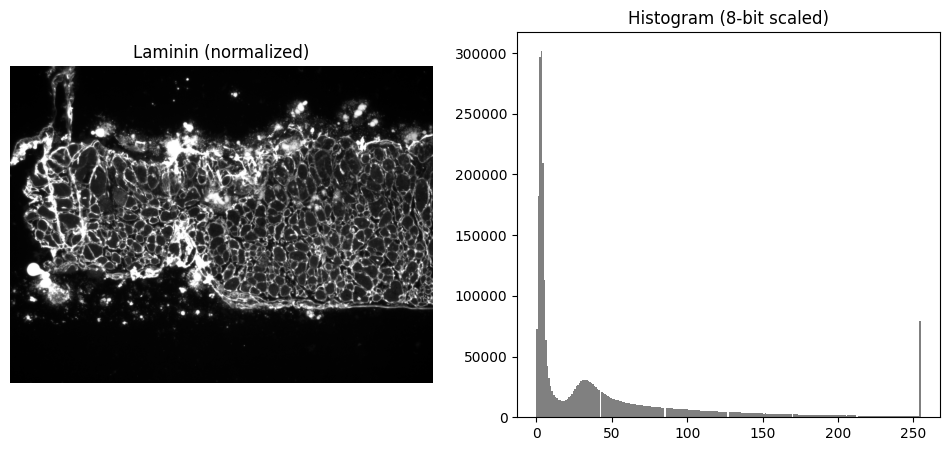

In [ ]:
# ===========================
# STEP 1. Upload Laminin ChannelImage（Upload）
# ===========================
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, exposure

uploaded = files.upload()
lam_path = list(uploaded.keys())[0]
lam_raw = io.imread(lam_path).astype(np.float32)

# If loaded as RGB Channel, Change to Grayscale
if lam_raw.ndim == 3:
    lam_raw = color.rgb2gray(lam_raw)

print("Laminin shape:", lam_raw.shape, "dtype:", lam_raw.dtype)

# ===========================
# STEP 2. Normalize Intensity
# ===========================
p1, p99 = np.percentile(lam_raw, (1, 99.8))
laminin_gray = np.clip((lam_raw - p1) / max(1e-6, (p99 - p1)), 0, 1)


# ===========================
# STEP 3. Fast Quanlity Control：Display Laminin and Histogram
# ===========================
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(laminin_gray, cmap="gray")
axs[0].set_title("Laminin (normalized)")
axs[0].axis("off")

axs[1].hist((laminin_gray*255).ravel(), bins=256, color="gray")
axs[1].set_title("Histogram (8-bit scaled)")
plt.show()



Final refined cells: 787
Final refined cells after merge-fix: 624 (thresh=0.14, small_area=130)
Final refined cells after correction: 497


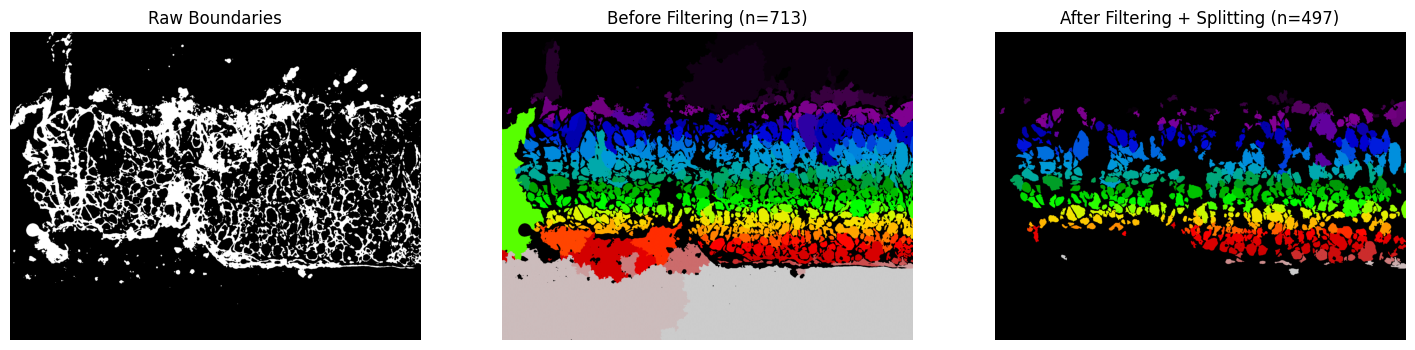

In [ ]:
# ===========================
# STEP 5–7. Use Laminin to Mark Boundaries and Segmentation
# ===========================
from skimage import filters, morphology, segmentation, measure
from scipy import ndimage as ndi
import numpy as np
from scipy.ndimage import binary_closing, distance_transform_edt
from skimage.measure import regionprops
from skimage.segmentation import watershed
from skimage.feature import peak_local_max


lam = laminin_gray.astype(np.float32)
p1, p99 = np.percentile(lam, (1, 99.8))
lam_n = np.clip((lam - p1) / max(1e-6, (p99 - p1)), 0, 1)

# —— Use Laminin to Measure Membrane/Inside Membrane
lam_blur = filters.gaussian(lam_n, sigma=1.0)
th = filters.threshold_otsu(lam_blur)
membrane = lam_blur > th
cell_interior = ~membrane
boundary_mask = membrane.copy()

# —— Generate Markers生成 markers
dist = ndi.distance_transform_edt(cell_interior)
local_max = morphology.h_maxima(dist, h=2)
markers, _ = ndi.label(local_max)

# —— Watershed (Use Laminin Edges)
edges = filters.sobel(lam_blur)
labeled_cells_all = segmentation.watershed(edges, markers=markers, mask=cell_interior)

# —— Small Fragments Cleaning
labeled_cells_all = morphology.remove_small_objects(labeled_cells_all, min_size=100)
num_cells_all = int(len(np.unique(labeled_cells_all)) - 1)


# STEP 8. Function: Apply min/max size filtering + watershed splitting
# ===========================
def refine_cells(label_map, min_size=200, max_size=5000, min_distance=15):
    new_label_map = np.zeros_like(label_map)
    new_label = 1

    for region in regionprops(label_map):
        coords = tuple(region.coords.T)
        area = region.area

        # Skip too small
        if area < min_size:
            continue

        # Normal cell
        if area <= max_size:
            new_label_map[coords] = new_label
            new_label += 1
        else:
            # Large blob → split with watershed
            mask = np.zeros_like(label_map, dtype=bool)
            mask[coords] = True

            distance = distance_transform_edt(mask)

            local_max = peak_local_max(distance,
                                       labels=mask,
                                       footprint=np.ones((25, 25)),
                                       min_distance=min_distance)

            markers = np.zeros_like(label_map, dtype=int)
            for i, (r, c) in enumerate(local_max, start=1):
                markers[r, c] = i

            labels_ws = watershed(-distance, markers, mask=mask)

            for ws_region in regionprops(labels_ws):
                if ws_region.area >= min_size:  # also enforce min size after splitting
                    coords_ws = tuple(ws_region.coords.T)
                    new_label_map[coords_ws] = new_label
                    new_label += 1

    return new_label_map

# ===========================
# STEP 9. Apply Refinement
# ===========================
labeled_cells_final = refine_cells(labeled_cells_all, min_size=200, max_size=5000)

num_cells_final = len(np.unique(labeled_cells_final)) - 1
print("Final refined cells:", num_cells_final)

# ---- STEP 9.x  Fix Over-Segmentation: Merge Weak Boundaries & Tiny Slivers ----
import numpy as np
from skimage.measure import regionprops
from skimage.morphology import dilation, disk
from skimage import color, util
try:
    from skimage import graph
except Exception:
    from skimage.future import graph

# 1) Generate A Laminin Grayscale for Evaluating Boundary Intensity
laminin_gray_f = util.img_as_float(laminin_gray)

# 2) RAG Merging Based on Boundary Intensity：
g = graph.rag_boundary(labeled_cells_final, laminin_gray_f)

if 0 in g:
    for n in list(g.neighbors(0)):
        g[0][n]['weight'] = 1.0
boundary_strength_thresh = 0.14 # Can Be Changed for Over-Segmentation / Under-Segmentation
labels_merged = graph.cut_threshold(labeled_cells_final, g, thresh=boundary_strength_thresh)

# 3) Splicing Small Fragments to Neighbors
labels_fixed = labels_merged.copy()
props = regionprops(labels_fixed)
small_area = 130
se = disk(1)

for r in props:
    if r.area < small_area:
        mask_r = (labels_fixed == r.label)
        ring = dilation(mask_r, se) & (~mask_r)
        neighbors = np.unique(labels_fixed[ring])
        neighbors = neighbors[neighbors != 0]
        if neighbors.size == 0:
            continue
        counts = [(n, np.sum(labels_fixed[ring] == n)) for n in neighbors]
        target = int(max(counts, key=lambda x: x[1])[0])
        labels_fixed[mask_r] = target

# 4) Update Final Counts
labeled_cells_final = labels_fixed
num_cells_final = len(np.unique(labeled_cells_final)) - 1
print(f"Final refined cells after merge-fix: {num_cells_final} (thresh={boundary_strength_thresh}, small_area={small_area})")


# STEP 9.1. Valid Fiber Filter
# ===========================
from skimage.measure import regionprops
import numpy as np

final_labeled_map = labeled_cells_final

cleaned_labeled_map = np.zeros_like(final_labeled_map)
new_label = 1

h, w = final_labeled_map.shape

for region in regionprops(final_labeled_map):
    if region.label == 0:
        continue

    area = region.area

    min_row, min_col, max_row, max_col = region.bbox

    # Check if Image Touches Border
    touches_border = (min_row == 0 or min_col == 0 or max_row == h-1 or max_col == w-1)

    if region.minor_axis_length > 0:
        aspect_ratio = region.major_axis_length / region.minor_axis_length
    else:
        aspect_ratio = 1000

    if region.perimeter > 0:
        # Circularity of Fiber: (4 * pi * Area) / (Perimeter^2)
        circularity = (4 * np.pi * region.area) / (region.perimeter ** 2)
    else:
        circularity = 0

    # Check if All Requirements Are Met
    # Fibers > ?, < ?, Circularity > ?
    is_valid_fiber = (area > 200 and area < 10000 and not touches_border and circularity > 0.25)

    if is_valid_fiber:
        # Create a Map if Fibers Valid
        coords = tuple(region.coords.T)
        cleaned_labeled_map[coords] = new_label
        new_label += 1

labeled_cells_final = cleaned_labeled_map
num_cells_final = len(np.unique(labeled_cells_final)) - 1

print("Final refined cells after correction:", num_cells_final)
# ===========================

# STEP 10. Visualize
# ===========================
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(boundary_mask, cmap="gray")
axs[0].set_title("Raw Boundaries")
axs[0].axis("off")

axs[1].imshow(labeled_cells_all, cmap="nipy_spectral")
axs[1].set_title(f"Before Filtering (n={num_cells_all})")
axs[1].axis("off")

axs[2].imshow(labeled_cells_final, cmap="nipy_spectral")
axs[2].set_title(f"After Filtering + Splitting (n={num_cells_final})")
axs[2].axis("off")

plt.show()



--- Diagnosis: Total of 125 Fibers Removed Because of ≤ 0.3 


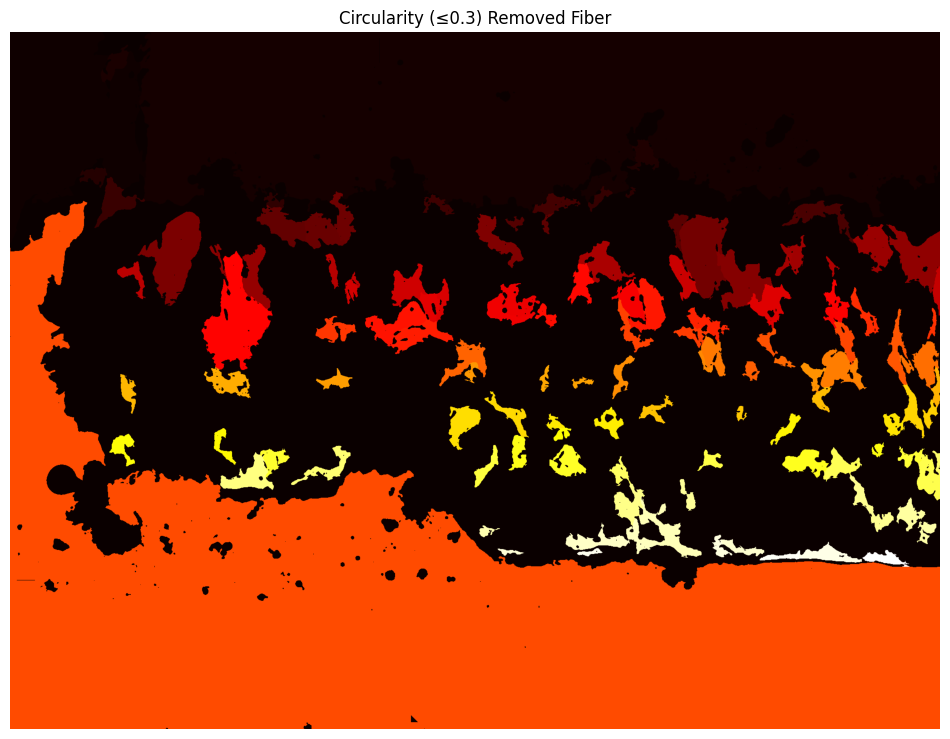

In [ ]:
# ===================================================================
#
# Diagnosis：Visualization of Fibers Removed by Circularity (≤ ?)
#
# ===================================================================

# --- Circularity Threshold (Please Ensure it is same as your last step) ---
CIRCULARITY_THRESHOLD = 0.25

# --- Find Fibers Removed Because of Circularity ---
rejected_fibers_map = np.zeros_like(labels_fixed) # 从过滤器之前的'labels_fixed'开始
new_label = 1

for region in regionprops(labels_fixed):
    if region.label == 0: continue

    # Calculation of Circularity
    if region.perimeter > 0:
        circularity = (4 * np.pi * region.area) / (region.perimeter ** 2)
    else:
        circularity = 0


    if circularity <= CIRCULARITY_THRESHOLD:
        if region.area > 100:
            coords = tuple(region.coords.T)
            rejected_fibers_map[coords] = new_label
            new_label += 1

num_rejected = new_label - 1

# --- Visualization Removed Fibers ---
if num_rejected > 0:
    print(f"\n--- Diagnosis: Total of {num_rejected} Fibers Removed Because of ≤ {CIRCULARITY_THRESHOLD} ")

    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(rejected_fibers_map, cmap='hot')
    ax.set_title(f'Circularity (≤{CIRCULARITY_THRESHOLD}) Removed Fiber')
    ax.axis('off')
    plt.show()
else:
    print(f"\n--- Diagnosis: None of the fibers ≤ {CIRCULARITY_THRESHOLD}, none removed ")

In [ ]:

# -------------------------------------------------------------------
# Step 1: Retrieve Segmentation Results
# -------------------------------------------------------------------
try:
    # Check if labeled_cells_final Valid
    if 'labeled_cells_final' in locals() and labeled_cells_final.max() > 0:
        print(f"✅ Successfully Detected Segmentation Results，Total {labeled_cells_final.max()} Valid Fiber。")
        segmentation_labels = labeled_cells_final
    else:
        raise NameError("Cannot find valid segmentation variable 'labeled_cells_final'。")
except NameError as e:
    print(f"❌ Error: {e}")
    print("Please ensure you have successfully ran all the codes in the program！")
    raise

# -------------------------------------------------------------------
# Step 2: Upload GFP and RFP Image
# -------------------------------------------------------------------
from google.colab import files
import warnings

print("\n--- Step 2: Please Upload your GFP and RFP ChannelImage ---")
print("Attention: To let the program recognize，please Ensure File names contain 'gfp' and 'rfp'。")
uploaded_files = files.upload()

# Recognize Files Based on File Names
try:
    file_paths = {
        'gfp': [name for name in uploaded_files.keys() if 'gfp' in name.lower()][0],
        'rfp': [name for name in uploaded_files.keys() if 'rfp' in name.lower()][0]
    }
    print("\nFile Recognized Successfully:")
    print(f"  GFP Image: {file_paths['gfp']}")
    print(f"  RFP Image: {file_paths['rfp']}")
except IndexError:
    raise ValueError("File Upload/Recognization Error：Please Ensure you have Uploaded a GFP File and a RFP File，and ensure File names contain 'gfp' and 'rfp'")


✅ Successfully Detected Segmentation Results，Total 497 Valid Fiber。

--- Step 2: Please Upload your GFP and RFP ChannelImage ---
Attention: To let the program recognize，please Ensure File names contain 'gfp' and 'rfp'。


Saving 131.2_0001_GFP.tiff to 131.2_0001_GFP (1).tiff
Saving 131.2_0001_RFP.tiff to 131.2_0001_RFP (1).tiff

File Recognized Successfully:
  GFP Image: 131.2_0001_GFP (1).tiff
  RFP Image: 131.2_0001_RFP (1).tiff



--- Step 3: Analyzing GFP 和 RFP Channel... ---
Calculated GFP PositiveThreshold: 0.446
Calculated RFP PositiveThreshold: 0.393

--- Step 4 & 5: Processing Sorting and Counting, Printing results... ---

--- ✅ Analyzing Result Statistics ---
Total Analyzing FiberCount: 497
-------------------------
GFP Positive (GFP+): 127 (25.55%)
RFP Positive (RFP+): 241 (48.49%)
-------------------------
GFP Positive Only(GFP+/RFP-): 12
RFP Positive Only(RFP+/GFP-): 126
Double Positive (GFP+/RFP+):    115
Double Negative (GFP-/RFP-):    244
-------------------------


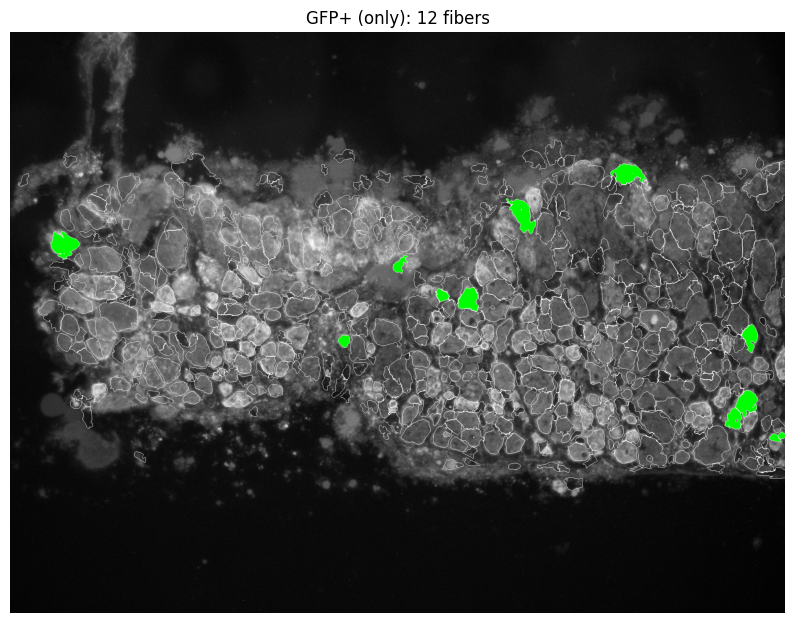

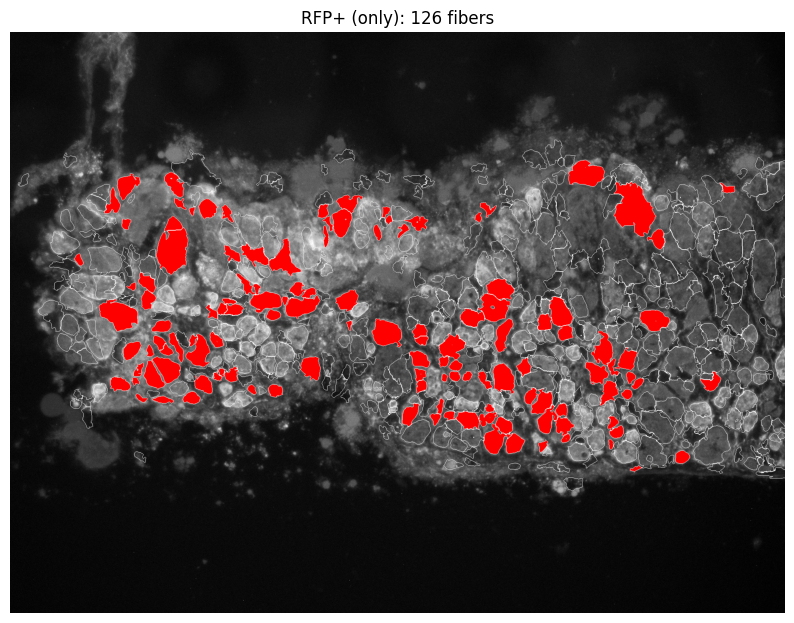

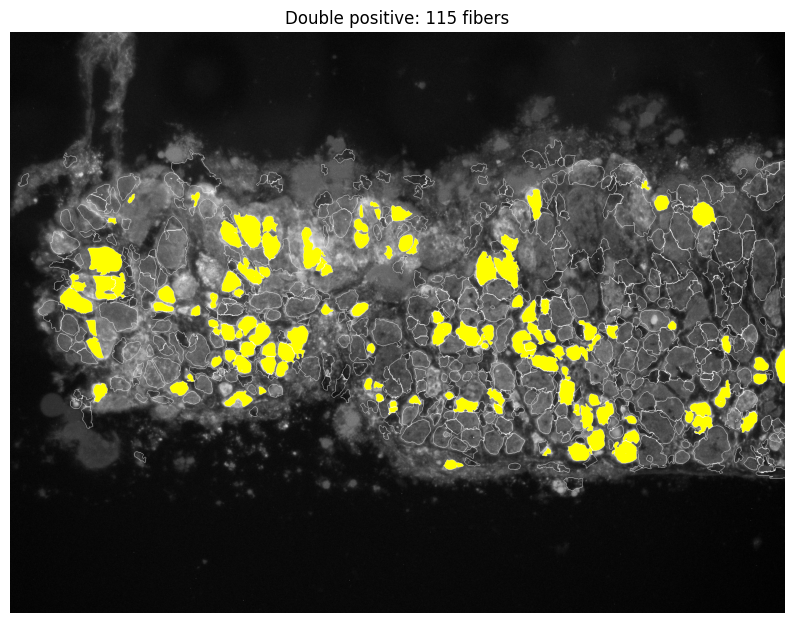

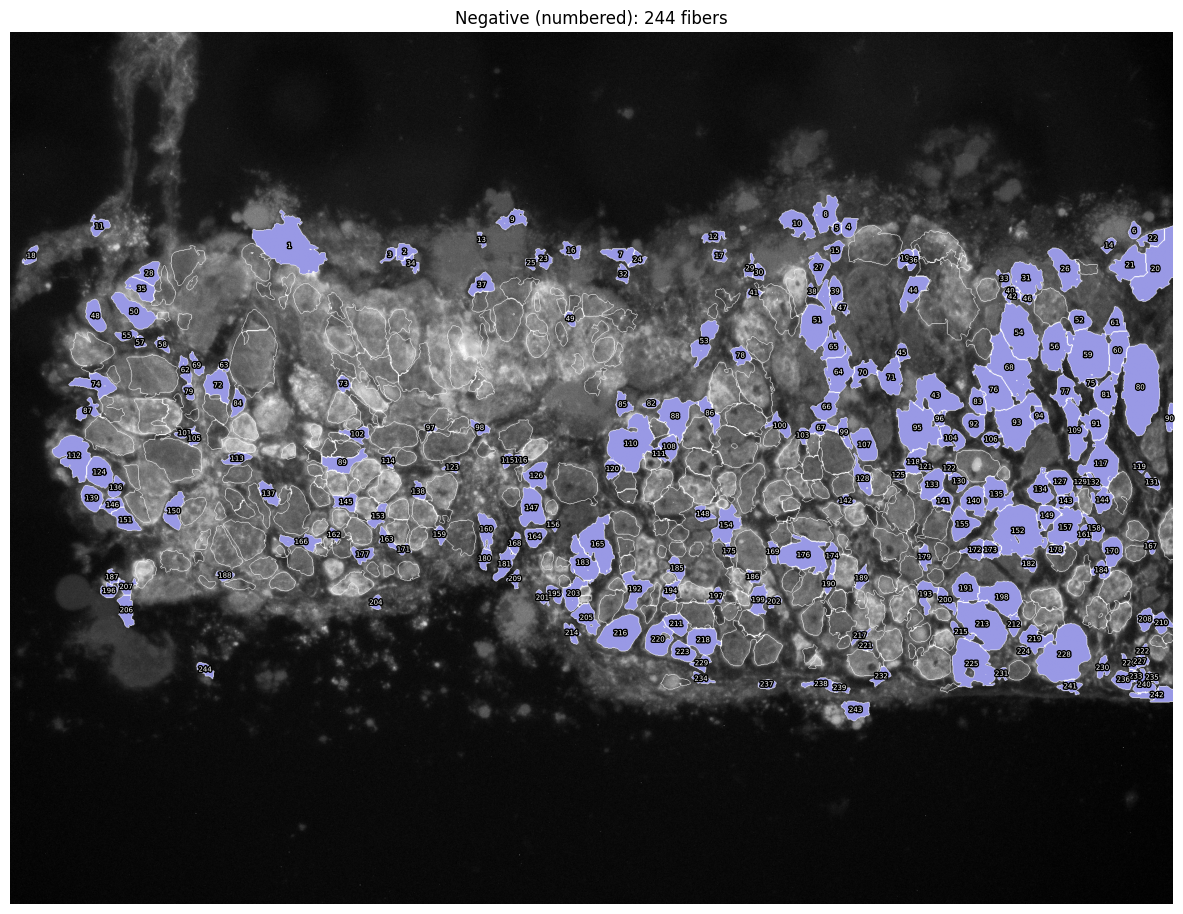

In [ ]:
# -------------------------------------------------------------------
# Step 3: Analyzing GFP and RFP Channels
# -------------------------------------------------------------------
print("\n--- Step 3: Analyzing GFP 和 RFP Channel... ---")

def analyze_channel(image_path, seg_labels):
    """An Independent Function Used to Load and Normalized Certain Channels' Otsu Threshold."""
    from skimage import io, color, exposure, filters, measure
    from skimage.transform import resize

    img_raw = io.imread(image_path)
    if img_raw.ndim == 3: img_gray = color.rgb2gray(img_raw)
    else: img_gray = img_raw.astype(np.float32)

    # Check if Image Sizes Match
    if img_gray.shape != seg_labels.shape:
        warnings.warn(f"Image Size Unmatch! Segmentation Maps ({seg_labels.shape}) vs {image_path.split('/')[-1]} ({img_gray.shape}). Resizing to match segmentation shape.")
        img_gray = resize(img_gray, seg_labels.shape, anti_aliasing=True)

    p1, p99 = np.percentile(img_gray, (1, 99.8))
    img_norm = exposure.rescale_intensity(img_gray, in_range=(p1, p99))

    # Only Calculate Threshold Inside Fibers
    signal_area = img_norm[seg_labels > 0]
    threshold = filters.threshold_otsu(signal_area) if len(signal_area) > 0 else 0.5
    return img_norm, threshold

gfp_norm, gfp_thresh = analyze_channel(file_paths['gfp'], segmentation_labels)
rfp_norm, rfp_thresh = analyze_channel(file_paths['rfp'], segmentation_labels)

print(f"Calculated GFP PositiveThreshold: {gfp_thresh:.3f}")
print(f"Calculated RFP PositiveThreshold: {rfp_thresh:.3f}")

## This step can be customed as you need ##
#gfp_thresh = 0.32  # <-- Custom GFP Threshold (Example: 0.35)
#rfp_thresh = 0.8  # <-- Custom RFP Threshold (Example: 0.40)

# -------------------------------------------------------------------
# Step 4, 5, 6: Sort, Statistics and Visualization
# -------------------------------------------------------------------
print("\n--- Step 4 & 5: Processing Sorting and Counting, Printing results... ---")

props_gfp = measure.regionprops(segmentation_labels, intensity_image=gfp_norm)
props_rfp = measure.regionprops(segmentation_labels, intensity_image=rfp_norm)

gfp_pos_labels = {region.label for region in props_gfp if region.mean_intensity > gfp_thresh}
rfp_pos_labels = {region.label for region in props_rfp if region.mean_intensity > rfp_thresh}
all_labels = {region.label for region in props_gfp}
total_fibers = len(all_labels)

if total_fibers == 0:
    print("Warning：No valid Fiber.")
else:
    # Calculate All Sortings
    double_pos_labels = gfp_pos_labels.intersection(rfp_pos_labels)
    gfp_only_labels = gfp_pos_labels - rfp_pos_labels
    rfp_only_labels = rfp_pos_labels - gfp_pos_labels
    negative_labels = all_labels - gfp_pos_labels - rfp_pos_labels

    # Print Statistics
    print("\n--- ✅ Analyzing Result Statistics ---")
    print(f"Total Analyzing FiberCount: {total_fibers}")
    print("-" * 25)
    print(f"GFP Positive (GFP+): {len(gfp_pos_labels)} ({len(gfp_pos_labels)/total_fibers:.2%})")
    print(f"RFP Positive (RFP+): {len(rfp_pos_labels)} ({len(rfp_pos_labels)/total_fibers:.2%})")
    print("-" * 25)
    print(f"GFP Positive Only(GFP+/RFP-): {len(gfp_only_labels)}")
    print(f"RFP Positive Only(RFP+/GFP-): {len(rfp_only_labels)}")
    print(f"Double Positive (GFP+/RFP+):    {len(double_pos_labels)}")
    print(f"Double Negative (GFP-/RFP-):    {len(negative_labels)}")
    print("-" * 25)

# ===========================
# Display All Visualized Fiber Subtypes
# ===========================
import matplotlib.pyplot as plt
from skimage import segmentation
import matplotlib.patheffects as pe
from skimage.measure import regionprops

# Gray background（Use GFP+RFP Mean）
gray = (gfp_norm.astype(float) + rfp_norm.astype(float)) / 2.0
base = np.dstack([gray, gray, gray])
edges = segmentation.find_boundaries(segmentation_labels, mode='outer')

def show_overlay(title, label_set, color_rgb):
    ov = base.copy()
    for lab in label_set:
        ov[segmentation_labels == lab] = color_rgb
    ov[edges] = [1, 1, 1]
    plt.figure(figsize=(10, 8))
    plt.imshow(ov)
    plt.title(f"{title}: {len(label_set)} fibers")
    plt.axis("off")
    plt.show()

_centroids = {reg.label: reg.centroid for reg in regionprops(segmentation_labels) if reg.label != 0}

def show_negative_with_counts(title, label_set, color_rgb):
    ov = base.copy()
    for lab in label_set:
        ov[segmentation_labels == lab] = color_rgb
    ov[edges] = [1, 1, 1]

    plt.figure(figsize=(15, 12))
    plt.imshow(ov)
    plt.title(f"{title}: {len(label_set)} fibers")
    plt.axis("off")

    for idx, lab in enumerate(sorted(label_set), start=1):
        if lab in _centroids:
            y, x = _centroids[lab]
            txt = plt.text(x, y, str(idx),
                           color='white', fontsize=5,
                           ha='center', va='center')
            txt.set_path_effects([pe.withStroke(linewidth=2, foreground='black')])

    plt.show()

show_overlay("GFP+ (only)",     gfp_only_labels,    [0, 1, 0])
show_overlay("RFP+ (only)",     rfp_only_labels,    [1, 0, 0])
show_overlay("Double positive", double_pos_labels,  [1, 1, 0])
show_negative_with_counts("Negative (numbered)", negative_labels, [0.6, 0.6, 0.9])


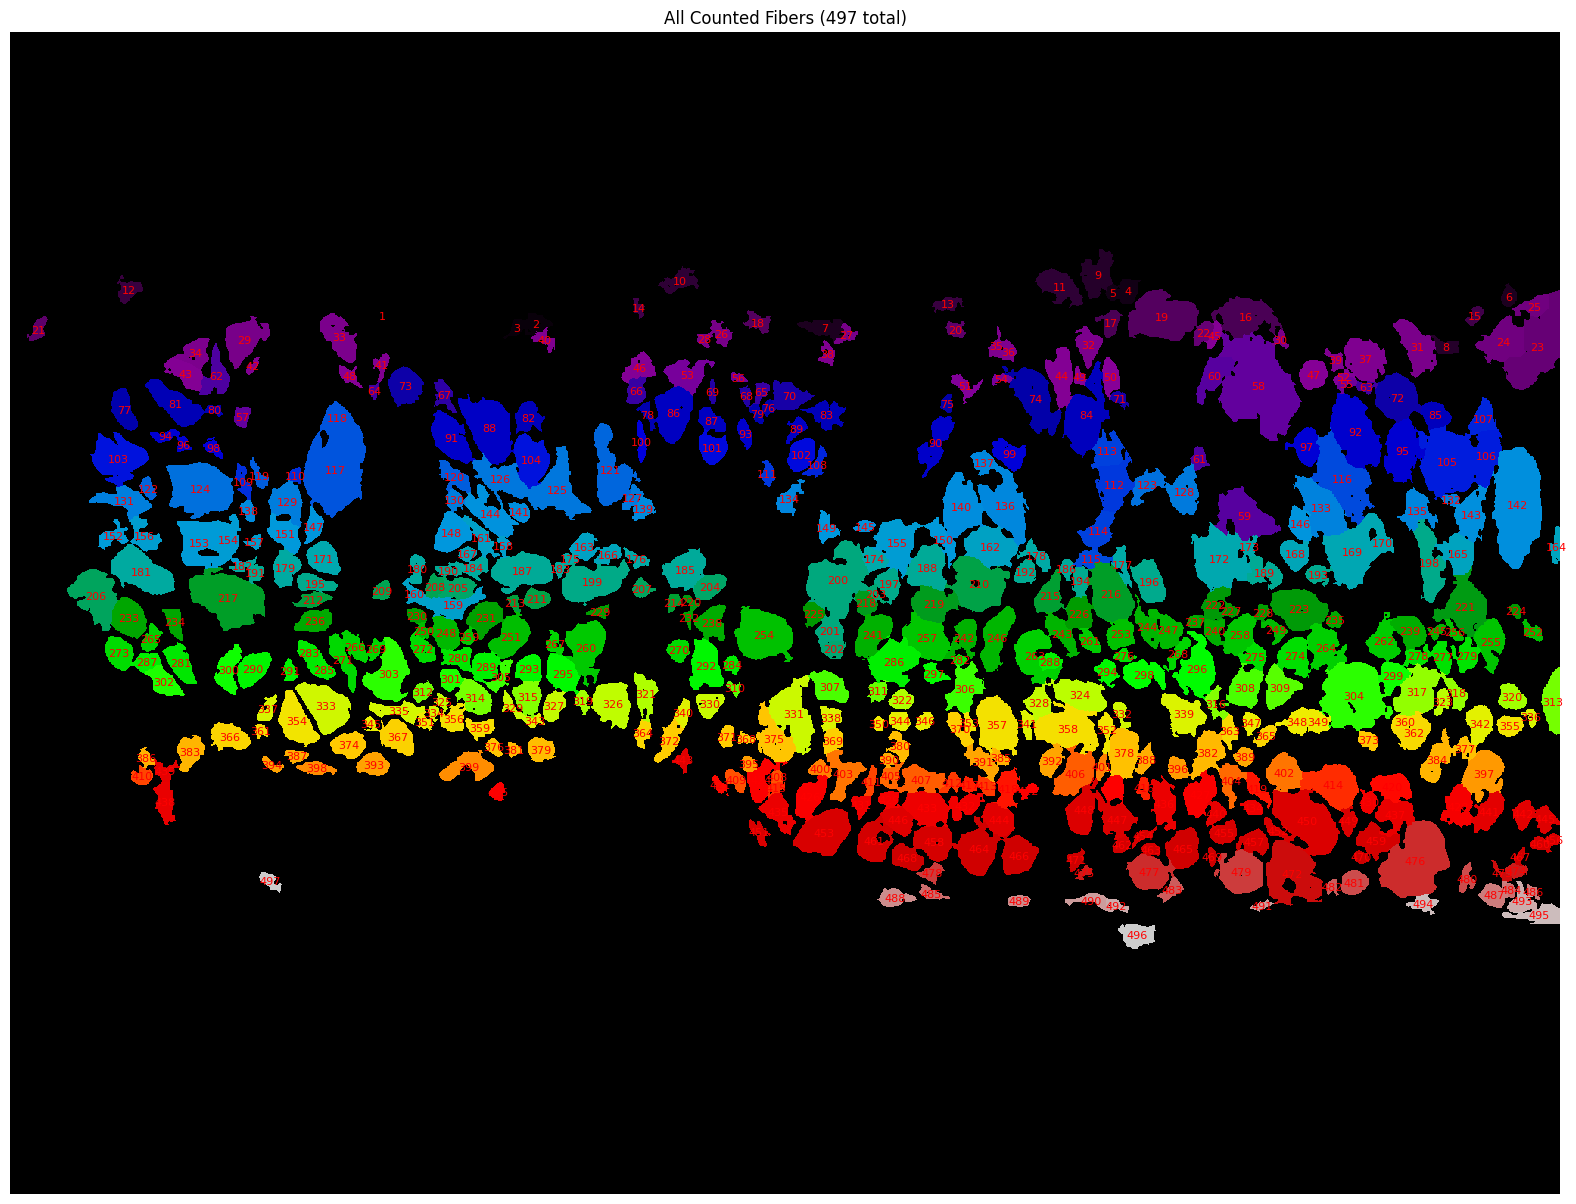

In [ ]:
# @title
# Visualize Final Valid Fibers
# Ensure you have ran all Steps，and Ensure "labeled_cells_final" already defined

from skimage.measure import regionprops
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 20))

plt.imshow(labeled_cells_final, cmap='nipy_spectral', interpolation='none')
plt.title(f"All Counted Fibers ({len(np.unique(labeled_cells_final)) - 1} total)")
plt.axis('off')

for region in regionprops(labeled_cells_final):
    if region.label == 0:
        continue

    y, x = region.centroid
    area = region.area

    text_label = f"{region.label}"

    plt.text(x, y, text_label,
             color='red',
             fontsize=8,
             ha='center',
             va='center',
             zorder=2)

plt.show()